# [NTDS'18] Final Project: Senator vote predictions based on graph features

## Students

* Team: `7`
* Students: `Mathias Gonçalves, Julien Heitmann, Mathieu Lamiot, Louis Landelle`
* Dataset: `US Senators`

## Foreword
The purpose of this project is to create a classifier than can, given some features generated using graph properties such as distance between nodes and eigenvectors of the laplacian of the graph, determine if a senator is going to vote in favor or against a specific bill.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

#Import distances
from scipy.spatial.distance import squareform

from scipy import sparse
import scipy.sparse.linalg

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from pyunlocbox import functions, solvers
import networkx as nx

import common

## 0 - Loading the data

All the data we import here was retrieved by the loading script `load_data.py`. Using this API takes some times, hence it is not repeated here and we simply load previously saved files.

In [2]:
senators = np.load(common.ACTIVE_SENATORS_FNAME)
adjacency = np.load(common.ADJACENCY_FNAME)
cosponsored = pd.read_pickle(common.COSPONSORED_FNAME)
DFvote_positions = pd.read_pickle(common.VOTE_POSITIONS_FNAME)
DFvotes = pd.read_pickle(common.VOTES_FNAME).set_index("id") #explain
DFsenators = pd.DataFrame.from_records(senators).set_index("id") #explain

### Indices ###
vote_ids = DFvotes.index.values
senator_ids = DFsenators.index.values

In [3]:
with open(common.COSPONSORS_FNAME, "rb") as ser_dict:
    cosponsors = pickle.load(ser_dict)

with open(common.COMMMITTEE_MEMBERS_FNAME) as fp:
    committee_members = json.load(fp)

with open(common.BILLS_FNAME) as fp:
    bill_info = json.load(fp)

In [4]:
#Convert features to numbers
DFvote_positions = DFvote_positions.replace('Yes',1)
DFvote_positions = DFvote_positions.replace('No',0)

#All others values should be NaN
DFvote_positions = DFvote_positions.apply(pd.to_numeric, errors='coerce')

### Diplay data
First, let's get a first look at the structure of the data. We first get a look at the senators:

In [5]:
senators[:2]

array([{'id': 'A000360', 'title': 'Senator, 2nd Class', 'short_title': 'Sen.', 'api_uri': 'https://api.propublica.org/congress/v1/members/A000360.json', 'first_name': 'Lamar', 'middle_name': None, 'last_name': 'Alexander', 'suffix': None, 'date_of_birth': '1940-07-03', 'gender': 'M', 'party': 'R', 'leadership_role': None, 'twitter_account': 'SenAlexander', 'facebook_account': 'senatorlamaralexander', 'youtube_account': 'lamaralexander', 'govtrack_id': '300002', 'cspan_id': '5', 'votesmart_id': '15691', 'icpsr_id': '40304', 'crp_id': 'N00009888', 'google_entity_id': '/m/01rbs3', 'fec_candidate_id': 'S2TN00058', 'url': 'https://www.alexander.senate.gov/public', 'rss_url': 'https://www.alexander.senate.gov/public/?a=RSS.Feed', 'contact_form': 'http://www.alexander.senate.gov/public/index.cfm?p=Email', 'in_office': True, 'dw_nominate': 0.323, 'ideal_point': None, 'seniority': '15', 'next_election': '2020', 'total_votes': 569, 'missed_votes': 26, 'total_present': 0, 'last_updated': '2018-11

The data frame here shows the vote of every participant for every senator for every bill. The bills are the column of the data frame and the index are the 100 senator numbered form 0 to 99. The columns are shown in reverse order since in the original dataframe, the first column is the oldest bill.

In [6]:
DFvote_positions[DFvote_positions.columns[::-1]] #reverse column order, most recent votes first

,C115:S2:C99,C115:S2:C98,C115:S2:C97,C115:S2:C96,C115:S2:C95,C115:S2:C94,C115:S2:C93,C115:S2:C92,C115:S2:C91,C115:S2:C90,...,C111:S2:C109,C111:S2:C108,C111:S2:C107,C111:S2:C106,C111:S2:C105,C111:S2:C104,C111:S2:C103,C111:S2:C102,C111:S2:C101,C111:S2:C100
0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,0.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DFvotes contains all the information about every bill. The bills are in the index:

In [7]:
DFvotes

,amendment.api_uri,amendment.number,amendment.sponsor,amendment.sponsor_id,amendment.sponsor_party,amendment.sponsor_state,amendment.sponsor_uri,bill.bill_id,bill.bill_uri,bill.latest_action,...,question,result,roll_call,session,time,total.no,total.not_voting,total.present,total.yes,vote_uri
id,,,,,,,,,,,,,,,,,,,,,
C115:S2:C274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hr695-115,https://api.propublica.org/congress/v1/115/bil...,Considered by Senate (Message from the House c...,...,On the Motion to Proceed,Motion to Proceed Agreed to,274,2,12:31:00,47,6,0,47,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hr695-115,https://api.propublica.org/congress/v1/115/bil...,Considered by Senate (Message from the House c...,...,On the Motion,Motion Agreed to,273,2,21:30:00,21,8,0,71,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pn2209-115,NaN,NaN,...,On the Cloture Motion,Cloture Motion Agreed to,272,2,11:22:00,1,4,0,95,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Motion,Motion Agreed to,271,2,20:22:00,12,1,0,87,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C270,https://api.propublica.org/congress/v1/115/ame...,S.Amdt. 4109 to S.Amdt. 4108,John Kennedy,K000393,R,La.,https://api.propublica.org/congress/v1/members...,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Amendment,Amendment Rejected,270,2,20:02:00,62,1,0,37,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C269,https://api.propublica.org/congress/v1/115/ame...,S.Amdt. 4109 to S.Amdt. 4108,John Kennedy,K000393,R,La.,https://api.propublica.org/congress/v1/members...,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Amendment,Amendment Rejected,269,2,19:43:00,66,1,0,33,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C268,https://api.propublica.org/congress/v1/115/ame...,S.Amdt. 4109 to S.Amdt. 4108,John Kennedy,K000393,R,La.,https://api.propublica.org/congress/v1/members...,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Amendment,Amendment Rejected,268,2,19:01:00,67,1,0,32,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Cloture Motion,Cloture Motion Agreed to,267,2,17:22:00,12,6,0,82,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sjres54-115,https://api.propublica.org/congress/v1/115/bil...,Held at the desk.,...,On the Joint Resolution,Joint Resolution Passed,266,2,15:03:00,41,3,0,56,https://api.propublica.org/congress/v1/115/sen...


DFsenators senator contains all the information about every senators:

In [8]:
DFsenators

,api_uri,contact_form,crp_id,cspan_id,date_of_birth,dw_nominate,facebook_account,fax,fec_candidate_id,first_name,...,state_rank,suffix,title,total_present,total_votes,twitter_account,url,votes_with_party_pct,votesmart_id,youtube_account
id,,,,,,,,,,,,,,,,,,,,,
A000360,https://api.propublica.org/congress/v1/members...,http://www.alexander.senate.gov/public/index.c...,N00009888,5,1940-07-03,0.323,senatorlamaralexander,202-228-3398,S2TN00058,Lamar,...,senior,None,"Senator, 2nd Class",0,569,SenAlexander,https://www.alexander.senate.gov/public,97.05,15691,lamaralexander
B001230,https://api.propublica.org/congress/v1/members...,https://www.baldwin.senate.gov/feedback,N00004367,57884,1962-02-11,-0.522,TammyBaldwin,202-225-6942,S2WI00219,Tammy,...,junior,None,"Senator, 1st Class",1,569,SenatorBaldwin,https://www.baldwin.senate.gov,94.17,3470,witammybaldwin
B001261,https://api.propublica.org/congress/v1/members...,https://www.barrasso.senate.gov/public/index.c...,N00006236,1024777,1952-07-21,0.533,johnbarrasso,202-224-1724,S6WY00068,John,...,junior,None,"Senator, 1st Class",0,569,SenJohnBarrasso,https://www.barrasso.senate.gov,96.65,52662,barrassowyo
B001267,https://api.propublica.org/congress/v1/members...,https://www.bennet.senate.gov/?p=contact,N00030608,1031622,1964-11-28,-0.207,senbennetco,202-228-5097,S0CO00211,Michael,...,senior,None,"Senator, 3rd Class",1,569,SenBennetCo,https://www.bennet.senate.gov,90.25,110942,SenatorBennet
B001277,https://api.propublica.org/congress/v1/members...,https://www.blumenthal.senate.gov/contact/,N00031685,21799,1946-02-13,-0.423,SenBlumenthal,202-224-9673,S0CT00177,Richard,...,senior,None,"Senator, 3rd Class",1,569,SenBlumenthal,https://www.blumenthal.senate.gov,90.81,1568,SenatorBlumenthal
B000575,https://api.propublica.org/congress/v1/members...,https://www.blunt.senate.gov/public/index.cfm/...,N00005195,45465,1950-01-10,0.430,SenatorBlunt,202-224-8149,S0MO00183,Roy,...,junior,None,"Senator, 3rd Class",0,569,RoyBlunt,https://www.blunt.senate.gov/public,98.20,418,SenatorBlunt
B001288,https://api.propublica.org/congress/v1/members...,https://www.booker.senate.gov/?p=contact,N00035267,84679,1969-04-27,-0.612,None,202-224-8378,S4NJ00185,Cory,...,junior,None,"Senator, 2nd Class",1,569,CoryBooker,https://www.booker.senate.gov,84.10,76151,SenCoryBooker
B001236,https://api.propublica.org/congress/v1/members...,https://www.boozman.senate.gov/public/index.cf...,N00013873,92069,1950-12-10,0.401,JohnBoozman,202-228-1371,S0AR00150,John,...,senior,None,"Senator, 3rd Class",0,569,JohnBoozman,https://www.boozman.senate.gov/public,98.23,27958,BoozmanPressOffice
B000944,https://api.propublica.org/congress/v1/members...,http://www.brown.senate.gov/contact/,N00003535,5051,1952-11-09,-0.438,None,202-228-6321,S6OH00163,Sherrod,...,senior,None,"Senator, 1st Class",1,569,SenSherrodBrown,https://www.brown.senate.gov,93.47,27018,SherrodBrownOhio


## 1 - First Feature: 2nd Laplacian eigenvector

In the following, we summarize what we found out during milestone 3. Laplacian eigenmaps of the network based on the votes of each senators provides a nice way of clustering senators that can be interpreted as their party. As we will see, it provides a powerful feature for our classifier as it already achieves good performances with only one feature coming from the 2nd dimension of the Laplacian eigenmaps.

First, let's review the graph we will use in this section. Each node is a senator and edges/weights are generated from 'DFvote_positions': for each pair of senator, we computed a distance based on their votes in common (cf. milestone 1). The graph we obtained is the presented below. It is strongly clustered into two parts, that are actually the parties (democrats and republicans).

/Users/Mathias/anaconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


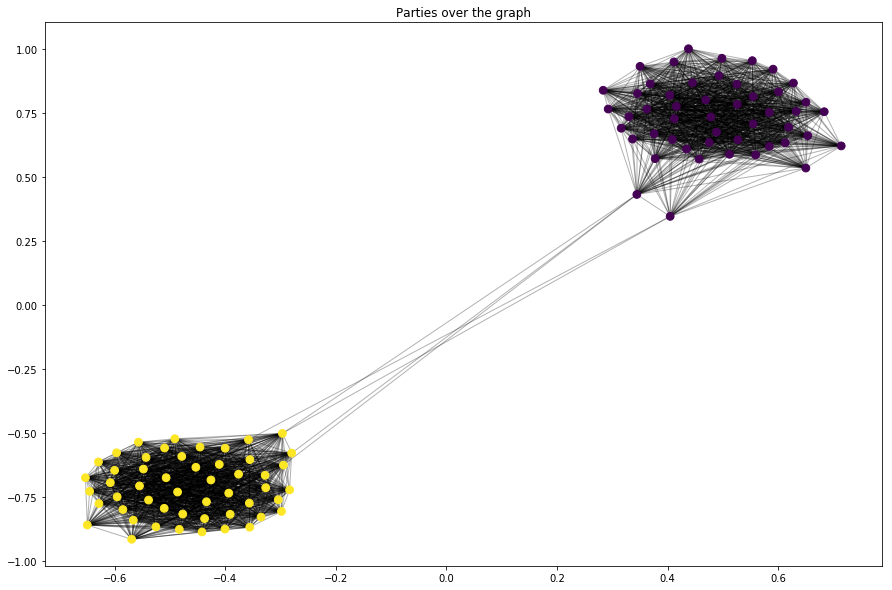

In [9]:
party = np.array([s["party"] for s in senators])
party_for_graph = (((party == 'R')*1)-0.5)*2

#Display the graph and the parties
graph = nx.from_scipy_sparse_matrix(scipy.sparse.csr_matrix(adjacency))
coords = nx.spring_layout(graph)  # Force-directed layout.
plt.figure(figsize= (15,10))
plt.subplot(111)
plt.title("Parties over the graph")
nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=party_for_graph)
nx.draw_networkx_edges(graph, coords, alpha=0.3)

Even if Republicans/Democrats could be a good feature to begin with, it seems that some senators are strongly coherent with their party whereas some other are a bit "in-between". Hence, a binary feature might not capture exactly the phenomenon.

In order to get a good measure of affiliation with the party, we will have a deeper look into the laplacian eigenmaps, as suggested in milestone 3.

In [10]:
# Create the Laplacian
degree_vect = np.sum(adjacency,axis=1)
degree_matrix = np.diag(degree_vect)
laplacian = degree_matrix-adjacency
laplacian_csr = sparse.csr_matrix(laplacian)
# Compute eigenvectors using sparse laplacian - Missing the last eigenvalue
d = 8
eig_val, eig_vect = sparse.linalg.eigsh(laplacian_csr, k=d, which = 'SM')
fiedler = eig_vect.T[1] # Fiedler vector

Here, the first 8 eigenvector are plotted to try to find if any of them gives a good amount of information from the covoting graph:

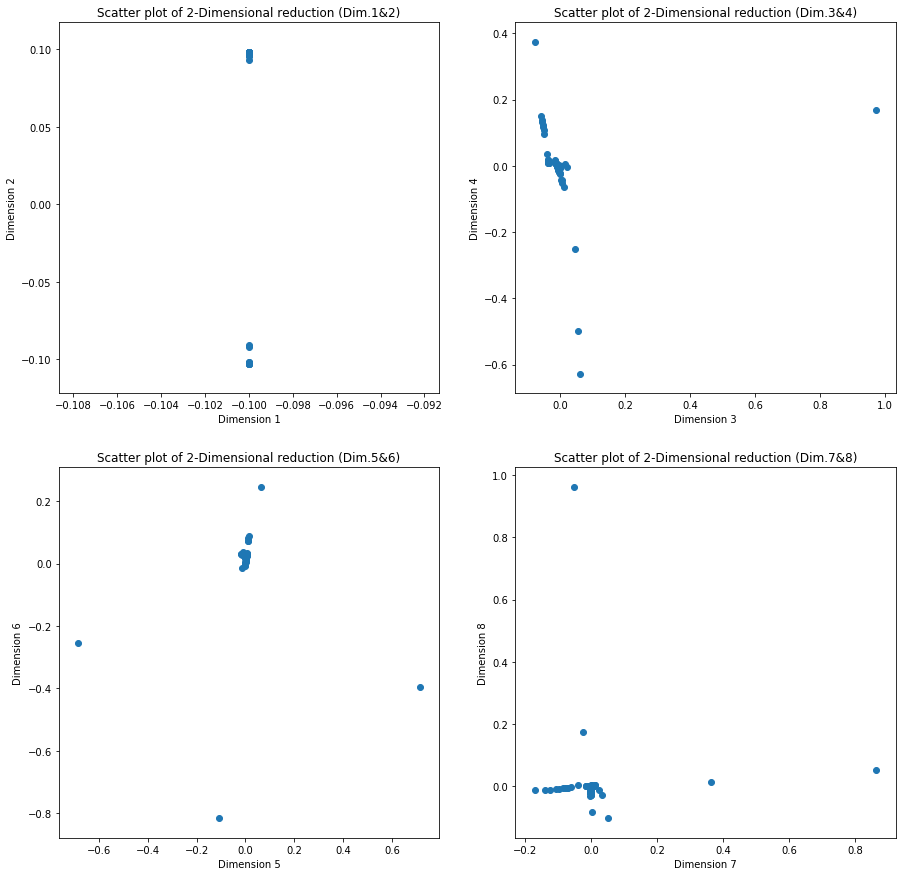

In [11]:
plt.figure(figsize= (15,15))
plt.subplot(221)
plt.scatter(eig_vect[:,0], eig_vect[:,1])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.1&2)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")


plt.subplot(222)
plt.scatter(eig_vect[:,2], eig_vect[:,3])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.3&4)")
plt.xlabel("Dimension 3")
plt.ylabel("Dimension 4")

plt.subplot(223)
plt.scatter(eig_vect[:,4], eig_vect[:,5])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.5&6)")
plt.xlabel("Dimension 5")
plt.ylabel("Dimension 6")

plt.subplot(224)
plt.scatter(eig_vect[:,6], eig_vect[:,7])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.7&8)")
plt.xlabel("Dimension 7")
plt.ylabel("Dimension 8")
plt.show()

As we can see, the dimensions 2, 4 and 7 seem to be the most relevant to separate the senators. Other dimensions lead to the separation of one (or a couple) of senators only which means they are likely not to be useful. Let's see if those three dimensions are actually useful.
We add to the following plots colors depending on the party of each senator (republicans and democrats) to try and interpret those dimensions.

Text(0, 0.5, 'Dimension 7')

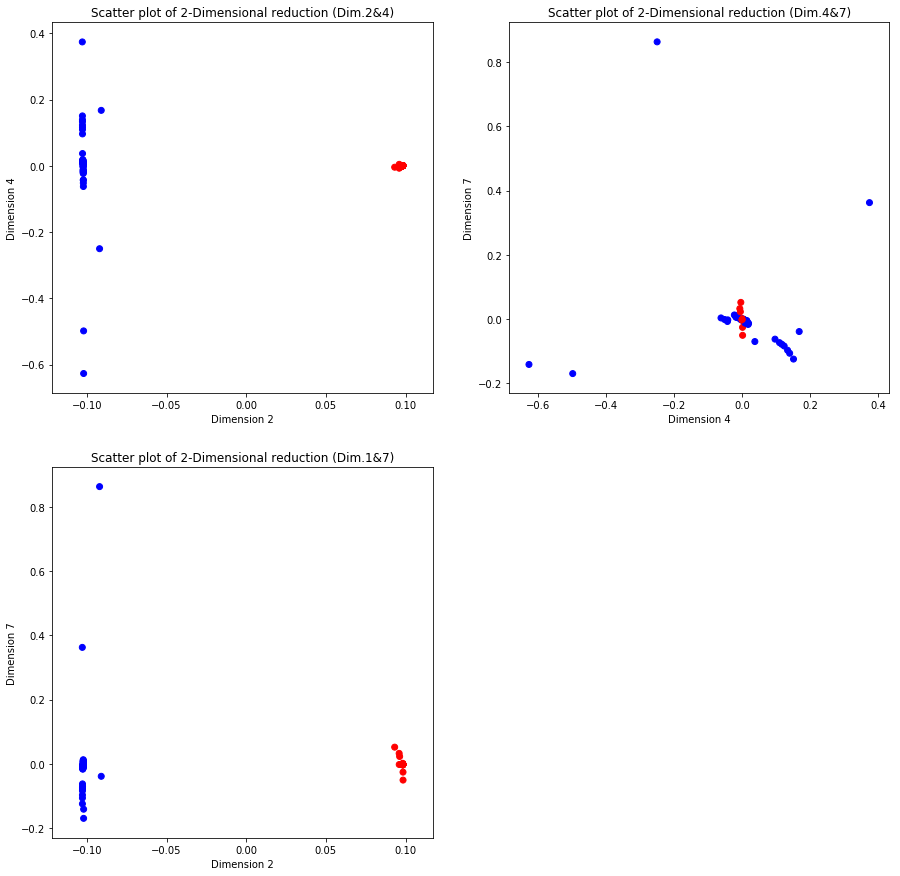

In [12]:
#Generate a colormap based on the party of each senator
color_map = np.repeat('b', party.size)
color_map[party == 'R'] = 'r'


plt.figure(figsize= (15,15))
plt.subplot(221)
plt.scatter(eig_vect[:,1], eig_vect[:,3],c=color_map)
plt.title("Scatter plot of 2-Dimensional reduction (Dim.2&4)")
plt.xlabel("Dimension 2")
plt.ylabel("Dimension 4")


plt.subplot(222)
plt.scatter(eig_vect[:,3], eig_vect[:,6],c=color_map)
plt.title("Scatter plot of 2-Dimensional reduction (Dim.4&7)")
plt.xlabel("Dimension 4")
plt.ylabel("Dimension 7")


plt.subplot(223)
plt.scatter(eig_vect[:,1], eig_vect[:,6],c=color_map)
plt.title("Scatter plot of 2-Dimensional reduction (Dim.1&7)")
plt.xlabel("Dimension 2")
plt.ylabel("Dimension 7")

Dimensions 4 and 7 seem to seperate only a few senators from the others, hence they are probably not a useful general feature. Notice that dimension 2 is strongly linked to the party of the senator and separate republicans from democrats. Hence, this dimension is particularly interesting as it can be easily interpreted. No specific interpretations were found for the other dimensions.
Thanks to this observation, we will use dimension 2 as a feature for our classifier: As each vote is introduced by a person affiliated to a party, our feature will be the distance of a senator to the party linked to the vote (Republican = 0.1, Democrats = -0.1) along that 2nd dimension of the eigenmaps.

In [13]:
def feature_laplacian_eigen_dim2(fiedler, df_votes, senator_id_num, vote_id):
    
    #Retrieve the feature of the senator
    senatorLoc = fiedler[senator_id_num]
    voteParty = df_votes.loc[vote_id, "amendment.sponsor_party"]
    
    if voteParty == 'D':
        voteLoc = -0.1
        #print("D")
    elif voteParty[0] == 'R':
        voteLoc = 0.1
        #print("R")
    else:
        voteLoc = senatorLoc #In this case, we want the feature not to count
    
    #Compute the distance between the two features to be used as a new feature
    distance = abs(voteLoc-senatorLoc)
    
    return distance 

## 2 - Second feature: Cosponsorship

The bills that are voted by the senator at the congress are often sponosored some senaotors. From there it was believed that is 2 senators are sponsoring the same laws they are very likely to vote the same way. So we are defining a graph that links the senator this time not using how much vote in common they have but using the number of co-cosponsored bills they have between each other.

In [14]:
def jaccard_similarity(list1, list2):
    """
    Computes the ration between the cardinallity of the intersection and the union of two set
    """
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection / union)

The weight in the graph between two senators is defined as the jaccard index or jaccard similarity between their set of sponsored bills. Here, the graph is built and the histogram of the weight is plotted:

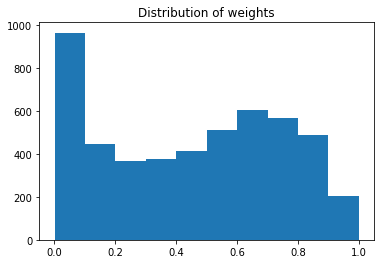

In [15]:
#Generate a graph based on cosponsored bills
n_senators = len(senators)
cospons_mat = np.zeros((n_senators, n_senators))

#Compute the weights between senators: a distance based on the cosponsorship feature
senator_pairs = ((i, j, x, y) for i, x in enumerate(senators) for j, y in enumerate(senators) if not x["id"] == y["id"])

for i, j, s1, s2 in senator_pairs:
    
    #common_bills = set(cosponsored[s1["id"]]).intersection(cosponsored[s2["id"]])
    #commonality = len(common_bills) / 20. 
    commonality = jaccard_similarity(cosponsored[s1["id"]], cosponsored[s2["id"]])
    cospons_mat[i, j] = commonality
    cospons_mat[j, i] = commonality

#From the feature differences, build distances and weights    
cospons_vect = squareform(cospons_mat)
kernel_width = cospons_vect.mean()
weights_vect = np.exp(-cospons_vect**2 / kernel_width**2)

#Visualize the weights distribution to assign a treshold
plt.hist(weights_vect)
plt.title('Distribution of weights')
plt.show()

Next, we threshold the weight because we consider that the senators that have low co-sponsorship are not linked at all.

In [16]:
#Treshold the matrix
weights_threshold = 0.6
adjacency_cospons = squareform(weights_vect)
adjacency_cospons[adjacency_cospons < weights_threshold] = 0 

Then we display the adjacency matrix of the graph:

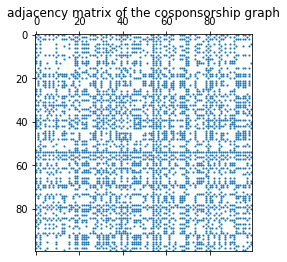

In [17]:
plt.spy(adjacency_cospons, markersize=1)
plt.title('adjacency matrix of the cosponsorship graph')
plt.show()

Finally the graph is ploted using the spring layout:

/Users/Mathias/anaconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


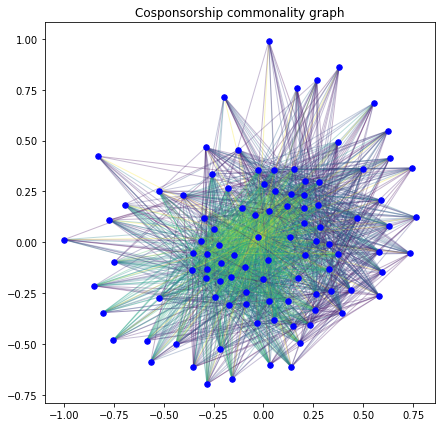

In [18]:
graph_cospons = nx.from_numpy_matrix(adjacency_cospons)
coords_cospons = nx.spring_layout(graph_cospons)

_, weights_cospons = zip(*nx.get_edge_attributes(graph_cospons,'weight').items())

plt.figure(figsize= (7,7))
plt.subplot(111)
plt.title("Cosponsorship commonality graph")
nx.draw_networkx_nodes(graph_cospons, coords_cospons, node_size=30, node_color='b')
nx.draw_networkx_edges(graph_cospons, coords_cospons, alpha=0.3, edge_color=weights_cospons, width=1)
plt.savefig("Co-spo-graph.png")
plt.show()

The commented method is the method used to get the list of senator sponsoring the bill given in argument. And the second method is the function called to generate the feature that will be used by the classifiers:

In [19]:
def feature_cosponsorship(adjacency_cospons, senator_id_num, cosponsors_num):
    distances = adjacency_cospons[senator_id_num, cosponsors_num]
    distance = np.sum(distances)
    
    return distance 

## 3 - Alternative features from graphs: Distances 

In this part, we will keep on working on the same graph. We will work on several ways of computing a distance from one senator to a law and use those distances as features for the final classification.


The first distance we can use is the shortest path distance between one senator and  the co-sponsors of the law. Note that the distance can be computed on all the graph we have.

In [20]:
def feature_shortest_path(senatorID,cosponsors, graph):
    min_distance = np.inf #We are only interested in the smallest distance
    for cosponsor in cosponsors: #We compute for each cosponsor the minimum distance to the senator.
        #Compute shortest path
        path =  nx.shortest_path(graph, source=senatorID, target=cosponsor, weight = zip(*nx.get_edge_attributes(graph,'weight').items()))
        #Compute the related distance
        distance = 0
        for k in range(0,len(path)-1):
            edge_weight = graph[path[k]][path[k+1]]
            distance = distance + 1/edge_weight['weight'] #Distance is the inverse of the weight !
        #compare to the minimum distance we already have
        min_distance = np.minimum(distance,min_distance)
    return distance

In the previous distance, we only take the shortest path into account. But maybe a senator is linked to another one through many different paths, which connects them more than if they were only connected by their smallest path. In order to take into account the entire graph in the computation of the distance, we will use the heat kernel: The idea is that if one senator sponsors a law, he could advertize it through his direct network, and diffuse the information. The time it takes to that information to diffuse to other senators could be a good measurment of how linked are two senators. The following distance is based on that diffusion principle:

In [21]:
#The following functions are adapted from milestone 3
def GFT(x,U):
    y = U.T.dot(x)
    return y 
def iGFT(x,U):
    y = U.dot(x)
    return y
def heat_kernel(e, t):
    return np.exp(-t*e)
def graph_filter(x, kernel, U, **kwargs):
    return iGFT(kernel*GFT(x,U),U)

#This is the new distanec we use
def feature_heat_kernel_distance(senatorID, cosponsors, graph, threshold, step):
    up_count = 200
    #Compute the eigenvectors for the GFT
    e, U = scipy.linalg.eigh(nx.laplacian_matrix(graph).todense())
    #Generate diracs at each cosponsor location
    f_in = np.zeros(100)
    f_in[cosponsors] = 1
    
    #Advance in time up until the desired heat is obtained at the target location
    t = 0
    count = 0
    f_out = f_in
    while(f_out[senatorID]<threshold*len(cosponsors) and count < up_count ):
        t = t + step
        count = count + 1 
        f_out = graph_filter(f_out, heat_kernel(e, step), U)
        f_out[cosponsors] = 1 #We assume that the heat generated at cosponsors is constant: they behave like heaters and don't lose their "heat" (ie. conviction in favor of the law)
    return t     

/Users/Mathias/anaconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


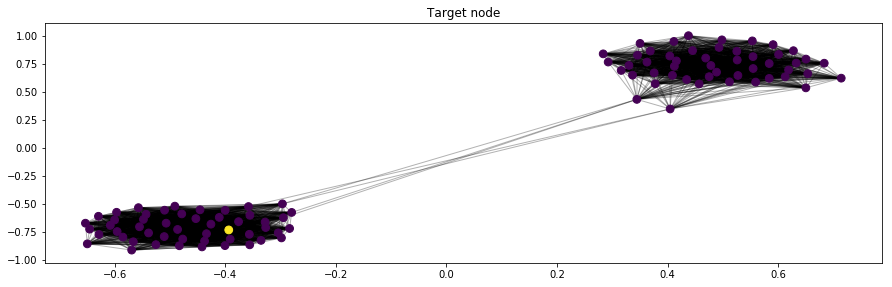

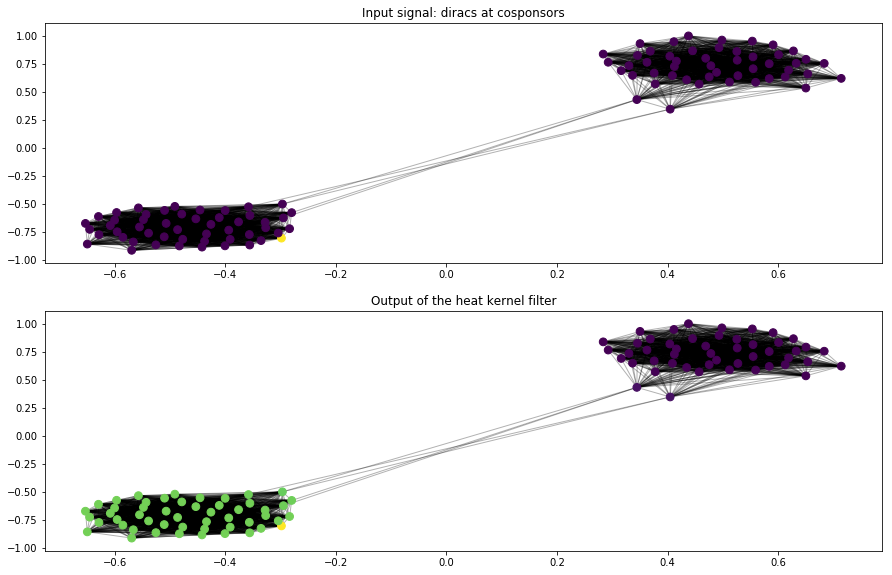

In [22]:
#Example
cosponsors_ex = [70]
e, U = scipy.linalg.eigh(nx.laplacian_matrix(graph).todense())
#Retrieve the distance
t = feature_heat_kernel_distance(5, cosponsors_ex, graph, 0.8, 0.01)
#Illustrate the initial signal, and the signal after diffusion during time t
f_in = np.zeros(100)
f_in[cosponsors_ex] = 1

f_tar = np.zeros(100)
f_tar[5] = 1


#Plot
plt.figure(figsize= (15,15))
plt.subplot(311)
plt.title("Target node")
nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=f_tar)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.figure(figsize= (15,15))
plt.subplot(312)
plt.title("Input signal: diracs at cosponsors")
nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=f_in)
nx.draw_networkx_edges(graph, coords, alpha=0.3)

f_out = f_in
t = 0
while(f_out[5]<0.8*len(cosponsors_ex)):
    t = t + 0.01
    f_out = graph_filter(f_out, heat_kernel(e, 0.01), U)
    f_out[cosponsors_ex] = 1 #We assume that the heat generated at cosponsors is constant: they behave like heaters and don't lose their "heat" (ie. conviction in favor of the law)
    
plt.subplot(313)
plt.title("Output of the heat kernel filter")
nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=f_out)
nx.draw_networkx_edges(graph, coords, alpha=0.3)

## 4- Third feature: Committees

Another way to group senators is through the system of congressional commitees. A congressional committee is a sub-organization that handles a specific duty. Committee membership enables members to develop specialized knowledge of the matters under their jurisdiction. Congressional committees provide valuable informational services to Congress by investigating and reporting about specialized subjects, allowing for informed legislation.

Committees are of two forms in the senate: 
- "standing" commmittees
- "special" or "select" committees

There exists a third type of committee, bicameral, thus also grouping senators:
- "joint" committees

We fetch all standing and special committees from the API to get a list from their URIs, among other info.

In [23]:
bills_uris = [v[1]["bill.bill_uri"] for v in DFvotes.iterrows()][:1]
bills = {b["bill_id"] : b["committee_codes"] for b in bill_info}

In [24]:
def map_senator_to_committees(senators_by_committee):
    """
    Function returning a dict containing all the committees a senator is memeber of.
    Key: senator_id, values: set(committee_id)
    """
    committees_by_senator = {}
    for cmt_id, s_id_list in senators_by_committee.items():
        for s_id in s_id_list:
            if not s_id in committees_by_senator:
                committees_by_senator[s_id] = set()
            committees_by_senator[s_id].add(cmt_id)
    return committees_by_senator
        
cmts_by_s = map_senator_to_committees(committee_members)

In the following cell, the number of senators that are part of a committee are counted:

In [25]:
print("There are", len(cmts_by_s.keys()), "individual senators with membership to >= 1 committee")

There are 98 individual senators with membership to >= 1 committee


In [26]:
# Creates a mapping senator_id -> senator_index in votes_results_matrix (alphabetical order of senator id)
s_ids = [s["id"] for s in senators]
s_index_from_id = {}
for s_index, s_id in enumerate(s_ids):
    s_index_from_id[s_id] = s_index
    
# Creates a function vote which gives the vote of some senator_id in some vote_id
def vote(senator_id,  vote_id):    
    return DFvote_positions[vote_id][s_index_from_id[senator_id]]

In [27]:
def comembership(cmt1, cmt2):
    """
    Computes comembership between two committees
    Args: cmt1, cmt2 : two lists of senatorIDs
    Returns: tuple (#comembers, comembers list)
    """
    s1, s2 = set(cmt1), set(cmt2)
    intersct = s1.intersection(s2)
    return len(intersct), intersct

This cell creates the graph of committees with commitees as notes and every two nodes are conected with an egde whose weight is equal to their co-membership amout. Also it keeps tracks of the maximum ration over the graph. In the last step, the weight is divided by the maximum amount to normalize wieghts:

In [28]:
n_cmts = len(committee_members.keys())

# Creates all pairs of distinct committees, of length |cmts|^2 - |cmts|, along with indexes
cmt_enum_pairs = [(i, j, c1, c2)
    for i, c1 in enumerate(committee_members.values())
    for j, c2 in enumerate(committee_members.values())
    if not c1 == c2]

# Creates cmt comembership graph adj matrix
comember_n_mat = np.zeros((n_cmts, n_cmts))

max_comembership = 0

for i, j, c1, c2 in cmt_enum_pairs:
    curr_comembership = comembership(c1, c2)[0]
    comember_n_mat[i, j] = curr_comembership
    max_comembership = max(max_comembership, curr_comembership)

comember_mat = comember_n_mat / max_comembership

The weight are thresholded as shown in the course:

In [29]:
thres = 0.3
comember_mat[comember_mat < thres] = 0

Here the graph of the committee co-membership is shown using a spring layout:

/Users/Mathias/anaconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


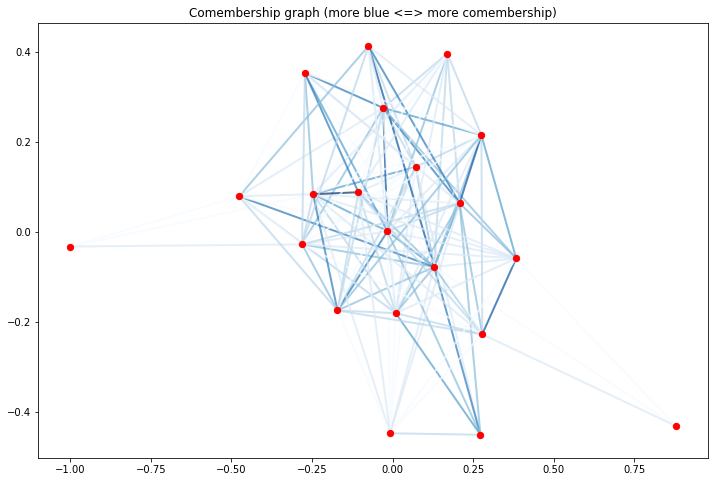

In [30]:
graph_comemb = nx.from_numpy_matrix(comember_mat)
coords_comemb = nx.spring_layout(graph_comemb)

_, weights_comemb = zip(*nx.get_edge_attributes(graph_comemb,'weight').items())

plt.figure(figsize= (12,8))
plt.subplot(111)
plt.title("Comembership graph (more blue <=> more comembership)")
nx.draw_networkx_nodes(graph_comemb, coords_comemb, node_size=40, node_color='r')#, node_color=U[:,0], vmin = 0, vmax= 1)
nx.draw_networkx_edges(graph_comemb, coords_comemb, alpha=0.7, edge_color=weights_comemb, edge_cmap=plt.cm.Blues, width=2)

The graph seems interesting since the connectiveness between two committees can vary a lot. It should then be possible to extract interesting features for our classifier. 

Indeed, as many bills are sponsored by a senate committee (actually most of the bills are sponsored by house committees but this is not is the scope of this project), we can compute the distance between a senator and a bill using the distance between the committees he is part of and the committee that sponsors the bill. This feature his computed here under:

In [31]:
def shortest_path(cmt_id1, cmt_id2, graph):
    #Compute shortest path
    path =  nx.shortest_path(graph, source=cmt_id1, target=cmt_id2, weight = zip(*nx.get_edge_attributes(graph,'weight').items()))
    #Compute the related distance
    distance = 0
    for k in range(0,len(path)-1):
        edge_weight = graph[path[k]][path[k+1]]
        distance = distance + 1/edge_weight['weight'] #Distance is the inverse of the weight !
    return distance, path

cmt_indices = {c : i for i, c in enumerate(committee_members.keys())}

This cell creates the `min_dist_mat` matrix where `min_dist_mat[senator, vote]` is equal to the shortest path between any of the senator's committee(s) and any committee that sponsors the voted bill.

In [32]:
PRINT_STEP = 50
MAX_DISTANCE = np.inf #Think about this

NO_CMT_FOR_SENATOR = 0
NO_CMT_FOR_BILL = 0

min_dist_mat = np.zeros(DFvote_positions.shape)
print(min_dist_mat.shape)
# For every senator...
for sen_i, senator in enumerate(senators):
    # Set the mat to shortest path from closest senator committee to vote committee
        
    # For each vote...
    for vote_i, col in enumerate(DFvote_positions):
        # Find closest committee and its shortest path to the vote committee
        if not senator["id"] in cmts_by_s:
            NO_CMT_FOR_SENATOR += 1
            min_distance = MAX_DISTANCE
        else:
            # Find the bill_id of this vote
            bill_id = DFvotes["bill.bill_id"][col]
            
            # Find the committees associated with this bill
            bill_cmts = bills.get(bill_id, [])
            
            # Remove House committees for associated committees
            bill_senate_cmts = [cmt for cmt in bill_cmts if cmt.startswith('S')]
            if not bill_senate_cmts:
                NO_CMT_FOR_BILL += 1
                min_distance = MAX_DISTANCE
            else:
                shortest_paths = [
                    shortest_path(cmt_indices[senator_cmt_id], cmt_indices[bill_cmt_id], graph_comemb)[0]
                    for senator_cmt_id in cmts_by_s[senator["id"]]
                    for bill_cmt_id in bill_senate_cmts
                ]
                min_distance = min(shortest_paths)            
        
        min_dist_mat[sen_i, vote_i] = min_distance

#print("NO_CMT_FOR_SENATOR", NO_CMT_FOR_SENATOR)
#print("NO_CMT_FOR_BILL", NO_CMT_FOR_BILL)

(100, 1528)


One last tweak : we can't use infinity for the shortest path for house bills or committee-less senators, as it is too large a value for the classifier. We also can't use 0 because this is a valid answer when the senator is coming from the same committee pushing the bill. We need to treshold down to a large value, but not too large, the values mapped to infinity in our feature matrix. We will arbitrarely pick twice the maximum valid value currently in our matrix, to represent a large senator/bill committee disconnect.


In [33]:
# Replacing the np.inf with twice the longest shortest path
max_shortest_dist = min_dist_mat[min_dist_mat != np.inf].max()
print("Maximum shortest distance :", max_shortest_dist)
min_dist_mat[min_dist_mat == np.inf] = max_shortest_dist * 2

Maximum shortest distance : 3.75


## 5 - Preparing the labels & features

To be able to compute our features we need to make sure that there is at least one senator in the list of cosponsors and that at least one of the two parties actually sponsors the bill. That's why a validity check method was created.

In [34]:
def check_vote_validity(df_votes, vote_id, cosponsors_id):
    valid = False;

    #Check that we have senator cosponsors
    for senator_id in cosponsors_id:
        if senator_id in senator_ids:
            valid = True
    #Check that the vote is affiliated to a party
    vote_party = df_votes.loc[vote_id, "amendment.sponsor_party"]
    valid = valid and (vote_party in ('D','R'))
    
    return valid

This the cell we used to generate the feature list and the labels. As it takes a lot of time tu run you can just skip it and load the data from the saved files: "features_full.npy" and "labels_full.npy" using the next cell. If you still want to use it please uncomment this cell.

In [35]:
# Uncomment in order to run it.

"""
labels = []
features = []

for vote_i, vote_id in enumerate(vote_ids):
    
    print("Working on vote", vote_id)
    bill_id = DFvotes.loc[vote_id, "bill.bill_id"]
    bill_cosponsors = cosponsors.get(bill_id, [])

    
    #Check if the vote will provide valid samples
    if check_vote_validity(DFvotes, vote_id, bill_cosponsors):
        print('Valid law')
        
        cosponsors_num = DFsenators.loc[bill_cosponsors, "id_num"].values #Retrieve cosponsors for that bill
        cosponsors_num = cosponsors_num[~np.isnan(cosponsors_num)]
        cosponsors_num=cosponsors_num.astype(int)
        print(cosponsors_num)
        for senator_i, senator_id in enumerate(senator_ids):
            senator_id_num = DFsenators.loc[senator_id, "id_num"]
            position = DFvote_positions.loc[senator_id_num, vote_id]
            #If this vote actually happened
            if not np.isnan(position):
                #Retrieve all the features for that vote/senator sample
                
                #Feature structure : laplacian_eigen_dim2 (party), ...
                feature = []
                
                #Co-vote features
                feature.append(feature_laplacian_eigen_dim2(fiedler, DFvotes, senator_id_num, vote_id))
                feature.append(feature_shortest_path(senator_id_num,cosponsors_num, graph))
                feature.append(feature_heat_kernel_distance(senator_id_num, cosponsors_num, graph, 0.3, 0.05))
                
                #Cosponsors features
                feature.append(feature_cosponsorship(adjacency_cospons, senator_id_num, cosponsors_num))
                feature.append(feature_shortest_path(senator_id_num,cosponsors_num, graph_cospons))
                feature.append(feature_heat_kernel_distance(senator_id_num, cosponsors_num, graph_cospons, 0.3, 0.05))
               
                #Committee features
                feature.append(min_dist_mat[senator_i, vote_i])

                #Append to the global features list
                labels.append(position)
                features.append(feature)
    else:
        print('Invalid law')
        
features = np.asarray(features)
np.save("features_full.npy",features)
np.save("labels_full.npy",labels)
"""
# print to avoid the notebook printing the commented code.
print("")

In [36]:
# Load the data from the saved files
features = np.load("features_full.npy")
labels = np.load("labels_full.npy")

## 6 - The classifiers

As using a classifier is not at the core of this course, we decided to test two different classifiers:
* A logistic regression classifier
* A Random forest classifier 

Splitting the data into a train set and test set

In [37]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=common.SEED)

Creating and fitting the linear classifier:

In [38]:
#Fit the classifier to the data
clf = LogisticRegression(random_state=common.SEED, solver='liblinear')
clf.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=2018, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Comparing the test error and the train error for the logistic regresion classifier:

In [39]:
#Compute the percentage of good classifications
score_te = clf.score(x_test, y_test)
score_tr = clf.score(x_train, y_train)
print("LogisticRegressionClassifier test score : " + str(score_te))
print("LogisticRegressionClassifier train score : " + str(score_tr))

LogisticRegressionClassifier test score : 0.731629392971246
LogisticRegressionClassifier train score : 0.7249466950959488


The linear model seem to have a good fit since the accuracy of of bothe the train set and test set are similar.

Now we create and fit the random forest classifier:

In [40]:
clfrf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=common.SEED)
clfrf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

Comparing the test error and the train error for the random forest classifier:

In [41]:
score_te = clfrf.score(x_test, y_test)
score_tr = clfrf.score(x_train, y_train)
print("RandomForestClassifier test score : " + str(score_te))
print("RandomForestClassifier train score : " + str(score_tr))

RandomForestClassifier test score : 0.8146964856230032
RandomForestClassifier train score : 0.9008528784648188


A bit of everfitting appears for the random forest classifier. But it wasn't managed to reduce it... Making a simpler model gave decrease of both train and test accuracy... 

After comparison of the two classifers the random forest classifer gave better prediction than the logistic regression classifier. The might be due to the fact that the data set is not linearly separable. Further more the 2nd laplacian eigenmap feature is categorical which the random forest classifier is most suitable for.